In [394]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

%matplotlib inline

In [395]:
#region_code is dropped because it is erroneous and the same data is available  in region
#has more values than there are regions. upon inspection it seems to be errors during entry, 8 is given as 80 etc,
#name of the waterpoint is unlikely to be helpful so dropped at first

In [396]:
dropped_cols =  [ 'recorded_by', 'region_code', 'payment', 'source_class', 'extraction_type']
test_data = pd.read_csv(r'C:\Users\HP\Downloads\test.csv', index_col='id').drop(dropped_cols,axis =1)
X = pd.read_csv(r'C:\Users\HP\Downloads\train_features.csv').drop(['id'] + dropped_cols,axis =1)
y = pd.read_csv(r'C:\Users\HP\Downloads\train_labels.csv').drop(['id'], axis=1)

In [397]:
# X['scheme_mgt_imputed'] = 0
# def replace_scheme_mgt_na(row):
#   if row['scheme_management']:
#     return row
#   mode = X.loc[:,(X['management'] == row['management'])]['scheme_management'].mode()
#   if mode.notna():
#     row['scheme_management'] = mode
#     row['scheme_mgt_imputed'] = 1
#   return row
# X = X.apply(replace_scheme_name_na,axis = 1)

In [398]:
# X['scheme_name_imputed'] = 0
# def replace_scheme_name_na(row):
#   if row['scheme_name']:
#     return row
#   mode = X.loc[:,(X['basin'] == row['basin'])]['scheme_name'].mode()
#   if mode.notna():
#     row['scheme_name'] = mode
#     row['scheme_name_imputed'] = 1
#   return row
# X = X.apply(replace_scheme_name_na,axis = 1)

In [399]:
class_labels = y['status_group'].unique()

In [400]:
RANDOM_SEED = 42

### Preprocessing and New Feature Creation

In [401]:
to_be_processed = [X, test_data]

In [402]:
for x in to_be_processed:
  x['date_recorded'] =  pd.to_datetime(x['date_recorded'], infer_datetime_format=True)  
  x['date_recorded'] = x.date_recorded.values.astype(np.int64) // 10 ** 9

In [403]:
# X['construction_year']= 2021 - X['construction_year']
# X['amount_per_population'] = X['amount_tsh']/(X['population']+1)
# X['log_date_recorded'] = np.log(X['date_recorded'])
# X['comb_scheme_name_mgt'] = X['scheme_name'].astype(str) + X['scheme_management']

In [405]:
non_num_cols = [c for c in X.columns if X[c].dtype == 'object' if c not in ['permit', 'public_meeting']]

In [407]:
for c in non_num_cols:
    for x in to_be_processed:
      x[c] = x[c].str.lower().str.strip().str.replace(re.compile('[\s\-\']'), '')

In [404]:
combined = pd.concat([X,y], axis = 1)

In [406]:
non_num_cols

['funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'scheme_management',
 'scheme_name',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'waterpoint_type',
 'waterpoint_type_group']

In [408]:
len(X)

59400

In [409]:
len(y)

59400

In [410]:
from sklearn.model_selection import train_test_split

In [411]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

In [412]:
train_combined = pd.concat([X_train, y_train], axis = 1)

In [413]:
test_empty_cols = { x:test_data[x].isnull().sum() for x in test_data.columns if test_data[x].isnull().sum() > 0}
train_empty_cols = { x: X[x].isnull().sum() for x in X.columns if X[x].isnull().sum() > 0}

# EDA

In [414]:
print('Test Empty Cols :{0}'.format(', '.join(['{0} ({1})'.format(k,v) for k,v in test_empty_cols.items()])))
print('Train Empty Cols: {0}'.format(', '.join(['{0} ({1})'.format(k,v) for k,v in train_empty_cols.items()])))

Test Empty Cols :funder (869), installer (877), subvillage (99), public_meeting (821), scheme_management (969), scheme_name (7092), permit (737)
Train Empty Cols: funder (3635), installer (3655), subvillage (371), public_meeting (3334), scheme_management (3877), scheme_name (28166), permit (3056)


In [415]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14850 entries, 50785 to 68707
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             14850 non-null  float64
 1   date_recorded          14850 non-null  int64  
 2   funder                 13981 non-null  object 
 3   gps_height             14850 non-null  int64  
 4   installer              13973 non-null  object 
 5   longitude              14850 non-null  float64
 6   latitude               14850 non-null  float64
 7   wpt_name               14850 non-null  object 
 8   num_private            14850 non-null  int64  
 9   basin                  14850 non-null  object 
 10  subvillage             14751 non-null  object 
 11  region                 14850 non-null  object 
 12  district_code          14850 non-null  int64  
 13  lga                    14850 non-null  object 
 14  ward                   14850 non-null  object 
 15

Notes:
* Quantity and Quantity Group Are Duplicated
* Payment and Payment Type are highly correlated(has same-ish data)
* Same as above with quality and quality group
* Source type and class are also highly correlated. But seems like a hierarchical relationship - Using source type will probalby help capture more intricate patterns
* waterpoint_type_group and waterpoint are the same except in just waterpoint_type communal pipe is split to multiple and single? - this division seems useful 

In [416]:
X.sample(10)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,management_group,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,waterpoint_type,waterpoint_type_group
57632,0.0,1364256000,worldvision,1760,dwe,36.637839,-3.256301,kwakipila,0,pangani,...,usergroup,neverpay,soft,good,enough,enough,spring,spring,other,other
15500,0.0,1300233600,planint,222,dwe,36.684915,-8.148777,kwamisama,0,rufiji,...,usergroup,neverpay,soft,good,seasonal,seasonal,machinedbh,borehole,communalstandpipe,communalstandpipe
58319,0.0,1310601600,oxfam,0,oxfam,30.820955,-2.414278,kwadaud,0,lakevictoria,...,usergroup,monthly,soft,good,enough,enough,spring,spring,communalstandpipe,communalstandpipe
46902,500.0,1300924800,co,314,co,36.996448,-7.592231,kwamadumla,0,rufiji,...,usergroup,onfailure,soft,good,enough,enough,river,river/lake,communalstandpipe,communalstandpipe
41459,0.0,1358985600,serikali,19,serikaliyakijiji,39.569523,-10.021226,kwanjumba,0,ruvuma/southerncoast,...,usergroup,unknown,soft,good,enough,enough,shallowwell,shallowwell,other,other
40358,0.0,1358812800,lga,371,lga,38.672733,-10.526459,balozi,0,ruvuma/southerncoast,...,usergroup,unknown,saltyabandoned,salty,dry,dry,machinedbh,borehole,handpump,handpump
47821,20.0,1359331200,gen,44,gen,39.573541,-9.809472,bombani,0,ruvuma/southerncoast,...,usergroup,perbucket,salty,salty,enough,enough,machinedbh,borehole,handpump,handpump
22117,0.0,1359590400,NaN,1558,NaN,34.731132,-4.999422,julias,0,internal,...,usergroup,unknown,unknown,unknown,dry,dry,shallowwell,shallowwell,other,other
2978,7.0,1363737600,germanyrepubli,1211,ces,37.225361,-3.259110,harambeesekondari,0,pangani,...,usergroup,perbucket,soft,good,enough,enough,spring,spring,communalstandpipe,communalstandpipe
20739,200.0,1299628800,anglicanchurch,1767,angli,34.590898,-9.786536,none,0,lakenyasa,...,usergroup,monthly,soft,good,enough,enough,river,river/lake,communalstandpipe,communalstandpipe


In [417]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  int64  
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  district_code          59400 non-null  int64  
 13  lga                    59400 non-null  object 
 14  ward                   59400 non-null  object 
 15  po

In [418]:
X.describe()

,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,district_code,population,construction_year
count,59400.000000,5.940000e+04,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,1.333012e+09,668.297239,34.077427,-5.706033e+00,0.474141,5.629747,179.909983,1300.652475
std,2997.574558,2.887629e+07,693.116350,6.567432,2.946019e+00,12.236230,9.633649,471.482176,951.620547
min,0.000000,1.034554e+09,-90.000000,0.000000,-1.164944e+01,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.301616e+09,0.000000,33.090347,-8.540621e+00,0.000000,2.000000,0.000000,0.000000
50%,0.000000,1.349827e+09,369.000000,34.908743,-5.021597e+00,0.000000,3.000000,25.000000,1986.000000
75%,20.000000,1.360368e+09,1319.250000,37.178387,-3.326156e+00,0.000000,5.000000,215.000000,2004.000000
max,350000.000000,1.386029e+09,2770.000000,40.345193,-2.000000e-08,1776.000000,80.000000,30500.000000,2013.000000


In [420]:
non_num_cols

['funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'scheme_management',
 'scheme_name',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'waterpoint_type',
 'waterpoint_type_group']

In [421]:
value_count_list = []
for c in non_num_cols:
  value_count_list.append((c, len(X[c].value_counts())))
print([print(x,y) for x,y in sorted(value_count_list, key=lambda x: x[1])])

management_group 5
quantity 5
quantity_group 5
quality_group 6
waterpoint_type_group 6
extraction_type_class 7
payment_type 7
source_type 7
waterpoint_type 7
water_quality 8
basin 9
source 10
scheme_management 12
management 12
extraction_type_group 13
region 21
lga 125
funder 1874
installer 1878
ward 2090
scheme_name 2491
subvillage 19186
wpt_name 36940
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [422]:
for c in non_num_cols:
  print(X[c].value_counts())
  print()
  print('-' * 5)

governmentoftanzania    9084
danida                  3114
hesawa                  2202
rwssp                   1374
worldbank               1349
                        ... 
tadeo                      1
wamembiki                  1
isf/tasaff                 1
netherla                   1
gg                         1
Name: funder, Length: 1874, dtype: int64

-----
dwe             17407
government       1891
hesawa           1395
rwe              1206
commu            1065
                ...  
dannida             1
tasf                1
yohanismgaya        1
hashi               1
christopher         1
Name: installer, Length: 1878, dtype: int64

-----
none                 3565
shuleni              1748
zahanati              830
msikitini             535
kanisani              323
                     ... 
mpenvyi                 1
kwamhan                 1
kwapetermshanga         1
kwamatataibrahim2       1
kwakayombonelson        1
Name: wpt_name, Length: 36940, dtype: int64

-----
lak

In [423]:
small = [x for x in non_num_cols if X[x].value_counts().count() <= 125]

In [424]:
X['scheme_management'].unique()

array(['vwc', 'other', nan, 'privateoperator', 'wug', 'waterboard', 'wua',
       'waterauthority', 'company', 'parastatal', 'trust', 'swc', 'none'],
      dtype=object)

Region code has too many  values (26) while tanzania has only 22 regions (https://en.wikipedia.org/wiki/Subdivisions_of_Tanzania)

In [445]:
X[(2 <= X['subvillage'].str.len()) & (X['subvillage'].str.len()  <= 3)]['subvillage'].value_counts() 
#Subvillages with few character names exist

ccm    65
nmc    25
juu    25
rc     20
sia    12
       ..
43      1
24b     1
kwa     1
18      1
vuo     1
Name: subvillage, Length: 98, dtype: int64

### Values in Test Set but not in training

In [446]:
for col in non_num_cols:
  a = set(test_data[col].unique())
  b = set(X[col].unique())
  c = a-b
  if len(c) > 0:
    print('Test set has {0} more values for column {1}'.format(len(c),col))
    print('They are', c)

Test set has 238 more values for column funder
They are {'mama', 'mzeemoh', 'aveda', 'dedandpriva', 'menonite', 'wingetisafari', 'bandikakilewa', 'jumuiyayadaralber_uae', 'mwikalekurawateruser', 'kwacheonrotaryclub', 'kkktmso', 'kyagoka', 'magufudi', 'eagtchurch', 'mountmeruflowers', 'anrikana', 'patrickmarwa', 'ubaloziwamarekani/dwe', 'mapingaprima', 'goldfinder', 'sharot', 'mlifa', 'dolfproject', 'uwamalu', 'sikongecoppermi', 'jaic', 'matimosangi', 'uniceffinidagermantanzani', 'ulangac', 'jandu', 'aljazera', 'kanutehaule', 'bindizi', 'ramadhandau', 'moyowosi', 'mzeeshekhe', 'dwspd', 'pangaboihealthcentre', 'rulengediocese', 'oldbank', 'newyorkgeneralmeeting', 'friendsofbariadi', 'igwachanyaseco', 'tanzanianaegypt', 'uniceffinidagermantanzania', 'mbunngemkono', 'reginaldmengi', 'hemedislam', 'cuso', 'villager', 'odc', 'jieun', 'kanisalakkt', 'mkumbukwa', 'tanzaniaandegyptcooperat', 'othodoxchurch', 'toberandfriendsfromaustral', 'lakailo', 'grailmission', 'mosha', 'finlandgovernmentfin

In [447]:
small

['basin',
 'region',
 'lga',
 'scheme_management',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'waterpoint_type',
 'waterpoint_type_group']

In [448]:
combined_copy = combined.copy(deep=True)

In [449]:
combined_copy = pd.concat([combined_copy, pd.get_dummies(combined_copy['status_group'])], axis =1 )

In [450]:
for x in small:
  if X[x].dtype != 'float64':

    print('Condition correlation by', x)
    selected = combined_copy[[x, 'functional', 'functional needs repair',	'non functional']]
    print(selected.groupby(x).sum()/ selected.groupby(x).count())
    print('--' * 4)

Condition correlation by basin
                         functional  functional needs repair  non functional
basin                                                                       
Internal                   0.575723                 0.071548        0.352730
Lake Nyasa                 0.653687                 0.049164        0.297148
Lake Rukwa                 0.407498                 0.110024        0.482478
Lake Tanganyika            0.483053                 0.115361        0.401586
Lake Victoria              0.497658                 0.096507        0.405835
Pangani                    0.600895                 0.053356        0.345749
Rufiji                     0.635406                 0.054789        0.309804
Ruvuma / Southern Coast    0.371689                 0.072557        0.555753
Wami / Ruvu                0.523802                 0.044931        0.431268
--------
Condition correlation by region
               functional  functional needs repair  non functional
region        

               functional  functional needs repair  non functional
quality_group                                                     
colored          0.502041                 0.110204        0.387755
fluoride         0.723502                 0.059908        0.216590
good             0.565941                 0.076823        0.357236
milky            0.544776                 0.017413        0.437811
salty            0.460828                 0.057170        0.482002
unknown          0.140725                 0.018657        0.840618
--------
Condition correlation by quantity
              functional  functional needs repair  non functional
quantity                                                         
dry             0.025136                 0.005924        0.968940
enough          0.652323                 0.072320        0.275357
insufficient    0.523234                 0.095842        0.380924
seasonal        0.574074                 0.102716        0.323210
unknown         0.269962 

In [453]:
# This code snippet showed that no lga value belongs to two regions..Therfore there is a hierarchical relationship
# between region and lga and lga can be used instead of region if dimensionality is not an issue.
# for value in test_data['region'].unique():
#   #print('Consider region :', value)
#   x = test_data[test_data['region'] == value]['lga'].unique()
#   for i in x:
#     if  (len(test_data[(test_data['region'] != value) & (test_data['lga'] == i)]) > 0):
#       print('For lga {0} is in another region except {1}'.format(value, i))

# for value in X['region'].unique():
#   #print('Consider region :', value)
#   x = X[X['region'] == value]['lga'].unique()
#   for i in x:
#     if  (len(X[(X['region'] != value) & (X['lga'] == i)]) > 0):
#       print('For lga {0} is in another region except {1}'.format(value, i))

In [454]:
large = [c for c in non_num_cols if X[c].nunique() >= 150]

In [455]:
for x in large:
  if X[x].dtype != 'float64':

    print('Condition correlation by', x)
    selected = combined_copy[[x, 'functional', 'functional needs repair',	'non functional']]
    print(selected.groupby(x).sum()/ selected.groupby(x).count())
    print('--' * 4)

Condition correlation by funder
                     functional  functional needs repair  non functional
funder                                                                  
0                      0.572716                 0.003861        0.423423
A/co Germany           0.466667                 0.066667        0.466667
Aar                    0.666667                 0.121212        0.212121
Abas Ka                1.000000                 0.000000        0.000000
Abasia                 0.837209                 0.046512        0.116279
...                         ...                      ...             ...
Zao                    0.000000                 0.000000        1.000000
Zao Water Spring       1.000000                 0.000000        0.000000
Zao Water Spring X     0.000000                 0.000000        1.000000
Zinduka                1.000000                 0.000000        0.000000
Zingibali Secondary    1.000000                 0.000000        0.000000

[1897 rows x 3 col

In [456]:
num_cols = list(set(X.columns) - set(non_num_cols))

In [457]:
len(num_cols)

11

In [458]:
##IQR Outlier removal - Added before boxplots
# long_min = X['longitude'].quantile(0.25) - 1.5*(X['longitude'].quantile(0.75) - X['longitude'].quantile(0.25))
# X.loc[X['longitude'] < long_min,'longitude'] = long_min

['latitude', 'amount_tsh', 'construction_year', 'population', 'gps_height', 'longitude', 'num_private', 'district_code', 'permit', 'date_recorded', 'public_meeting']


D:\Users\HP\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
D:\Users\HP\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
D:\Users\HP\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
D:\Users\HP\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],
D:\Users\HP\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
D:\Users\HP\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
D:\Users\HP\anaconda3\lib\site-packages\matplotlib\cbook\__init__

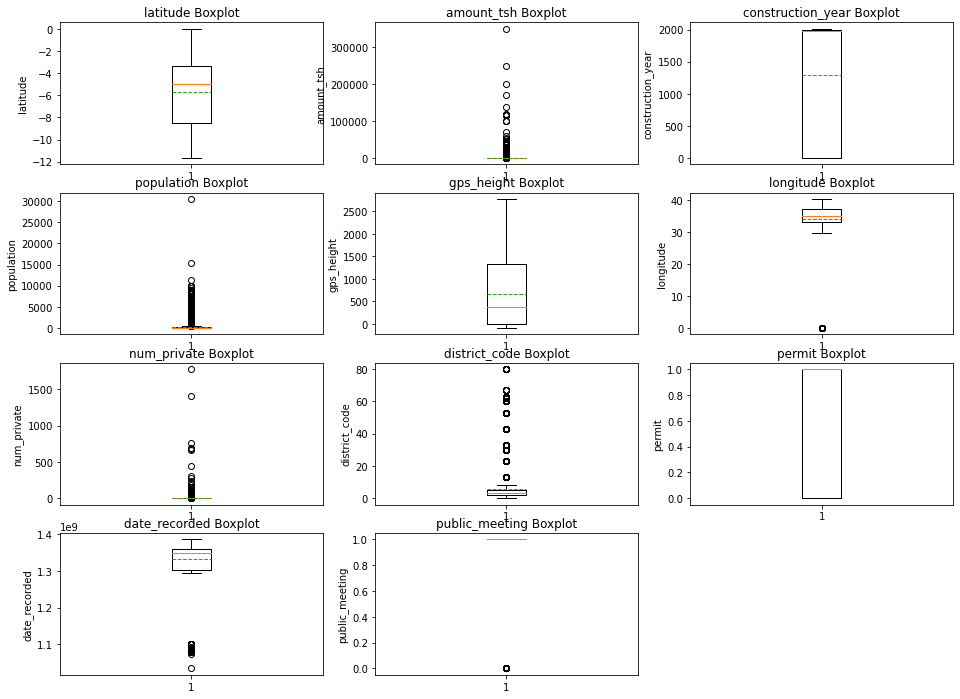

In [459]:

plt.figure(figsize=[16,12])
print(num_cols)
for i in range(1, len(num_cols)+1):
  plt.subplot(4,3, i)
  col = num_cols[i-1]
  plt.boxplot(x=X[col], showmeans = True, meanline = True)
  plt.title('{0} Boxplot'.format(col))
  plt.ylabel('{0}'.format(col))


In [460]:
y['status_group'].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

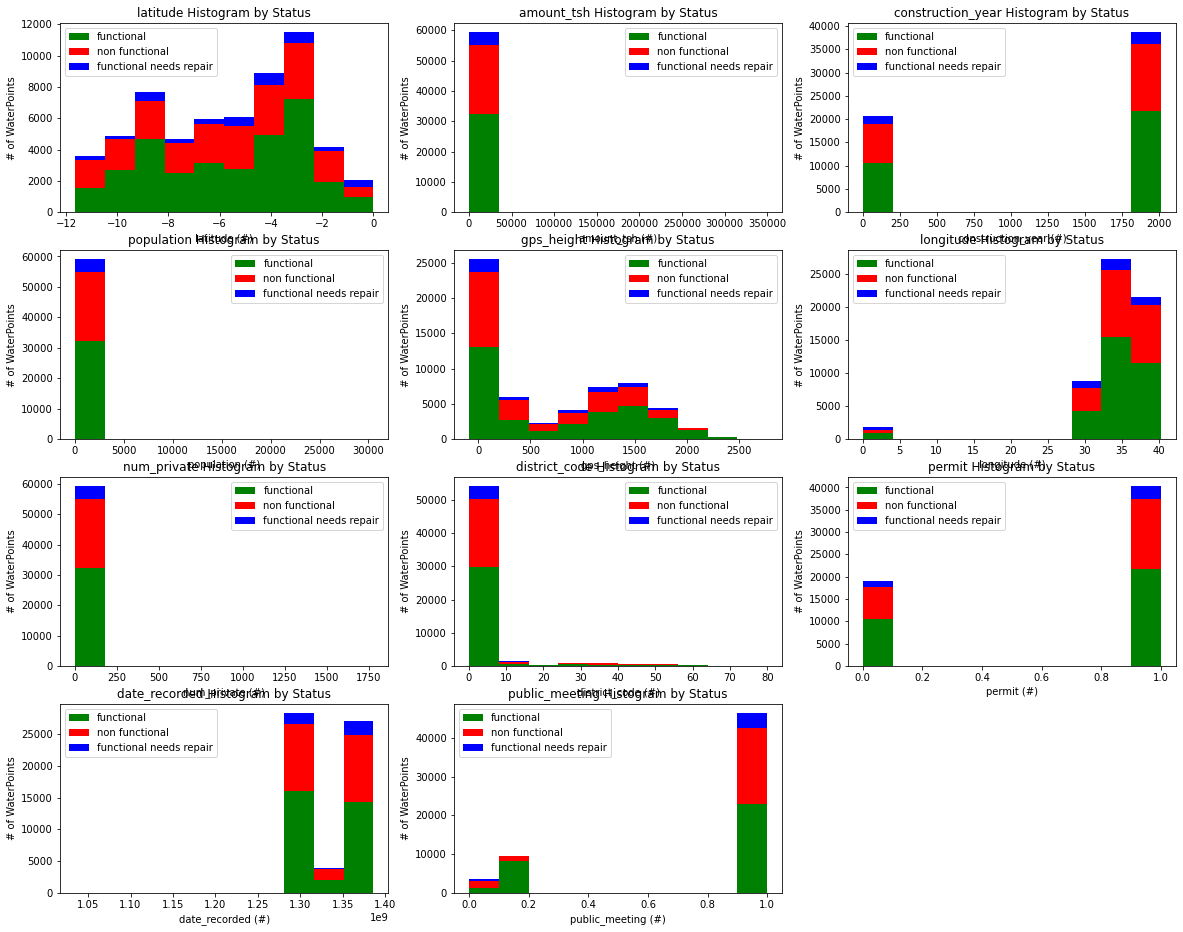

In [461]:
plt.figure(figsize=[20,16])

for i in range(1, len(num_cols)+1):
  plt.subplot(4,3, i)
  col = num_cols[i-1]
  plt.hist(x = [combined_copy[combined_copy['status_group'] == j][col] for j in y['status_group'].unique()],  stacked=True, color = ['g','r', 'b'],label = y['status_group'].unique())
  plt.title('{0} Histogram by Status'.format(col))
  plt.xlabel('{0} (#)'.format(col))
  plt.ylabel('# of WaterPoints')
  plt.legend()

In [462]:
X[small].nunique(
  
)

basin                      9
region                    21
lga                      125
scheme_management         12
extraction_type_group     13
extraction_type_class      7
management                12
management_group           5
payment_type               7
water_quality              8
quality_group              6
quantity                   5
quantity_group             5
source                    10
source_type                7
waterpoint_type            7
waterpoint_type_group      6
dtype: int64

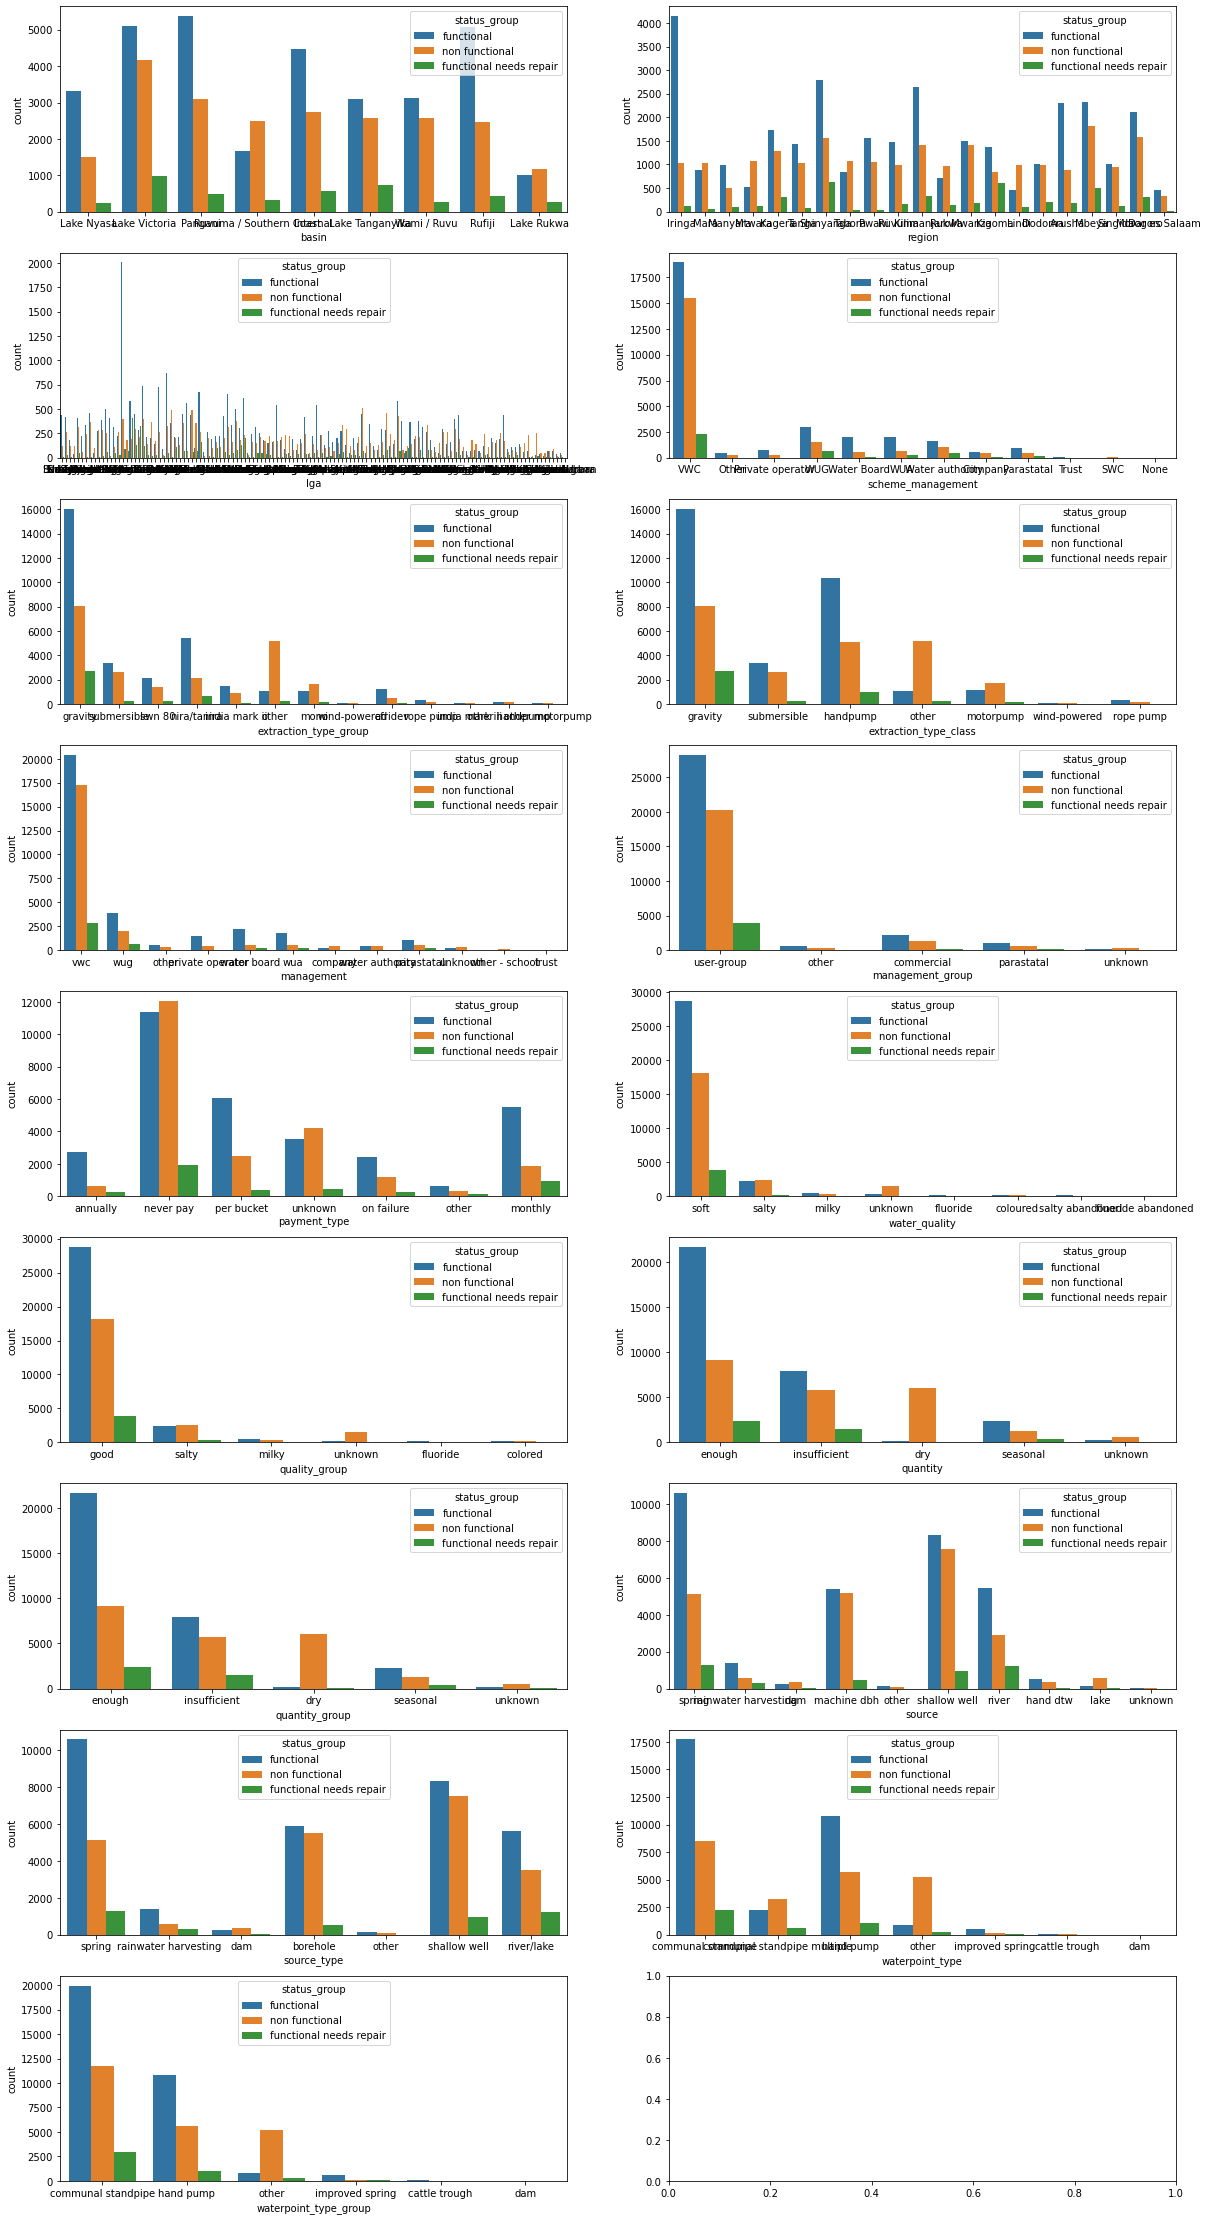

In [496]:
import math
fig, saxis = plt.subplots(math.ceil(len(small)/2), 2,figsize=(20,40))

for i in range(len(small)):
  sns.countplot(x = small[i], hue = 'status_group', data=combined_copy, ax = saxis[i//2, i%2])


### Continuous Correlation

In [466]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)


In [ ]:
correlation_heatmap(combined_copy)

8889

### Categorical Correlation

In [469]:
# missing_cats = [i for i in X.columns if X[i].isna().sum()>0]
# import scipy.stats as ss
# def cramers_v(x, y):
#     confusion_matrix = pd.crosstab(x,y)
#     chi2 = ss.chi2_contingency(confusion_matrix)[0]
#     n = confusion_matrix.sum().sum()
#     phi2 = chi2/n
#     r,k = confusion_matrix.shape
#     phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
#     rcorr = r-((r-1)**2)/(n-1)
#     kcorr = k-((k-1)**2)/(n-1)
#     return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [ ]:
# for x in missing_cats:
#   print('Correlations for {0}'.format(x))
#   for i in list(set(non_num_cols) - set(x)):
#     print('Correlation of {0} and {1} : {2}'.format(x, i, cramers_v(X_train[x],X_train[i])))
#   print('-'*4)

###  Imputation, Training and Validation

In [471]:
[(i,  X[i].isna().sum()) for i in X.columns if X[i].isna().sum()>0]

[('funder', 3635),
 ('installer', 3655),
 ('subvillage', 371),
 ('public_meeting', 3334),
 ('scheme_management', 3877),
 ('scheme_name', 28166),
 ('permit', 3056)]

In [474]:
from catboost import Pool, CatBoostClassifier

In [475]:
catboost_model = CatBoostClassifier( loss_function='MultiClass',
    eval_metric='AUC')

In [476]:
cat_ids = non_num_cols + ['permit', 'public_meeting']

In [ ]:
# X['scheme_mgt_imputed'] = 0
# X['scheme_name_imputed'] = 0
# test_data['scheme_mgt_imputed'] = 0
# test_data['scheme_name_imputed'] = 0

# def replace_scheme_mgt_na(row):
#   if row['scheme_management']:
#     return row
#   mode = X_train.loc[:,(X_train['management'] == row['management'])]['scheme_management'].mode()
#   if mode.notna():
#     row['scheme_management'] = mode
#     row['scheme_mgt_imputed'] = 1
#   return row
# def replace_scheme_name_na(row):
#   if row['scheme_name']:
#     return row
#   mode = X_train.loc[:,(X_train['basin'] == row['basin'])]['scheme_name'].mode()
#   if mode.notna():
#     row['scheme_name'] = mode
#     row['scheme_name_imputed'] = 1
#   return row

In [478]:
for x in [X_train,X_test, test_data]:
    x.loc[:,'public_meeting'].fillna( X_train['public_meeting'].mode(), inplace=True)
    x.loc[:,'permit'].fillna(X_train['permit'].mode(), inplace=True)


# X_train = X_train.apply(replace_scheme_mgt_na, axis = 1)
# X_test = X_test.apply(replace_scheme_mgt_na, axis = 1)
# test_data = test_data.apply(replace_scheme_mgt_na,axis = 1)

# X_train = X_train.apply(replace_scheme_name_na,axis = 1)
# X_test = X_test.apply(replace_scheme_name_na,axis = 1)
# test_data = test_data.apply(replace_scheme_name_na,axis = 1)
    
e = 'subvillage'
c = X_train[e].value_counts()
replaced_values = sorted(c.index[c <= 1])
X_train.loc[X_train[e].isin(replaced_values),e] = 'low_freq'
X_test.loc[X_test[e].isin(replaced_values),e] = 'low_freq'
test_data.loc[test_data[e].isin(replaced_values),e] = 'low_freq'

D:\Users\HP\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
D:\Users\HP\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [479]:
X_train.fillna('unknown', inplace=True)
X_test.fillna('unknown', inplace=True)

D:\Users\HP\anaconda3\lib\site-packages\pandas\core\frame.py:4147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [480]:
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_ids)
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_ids)
X_t, X_eval, y_t, y_eval = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=RANDOM_SEED)
eval_pool = Pool(data=X_eval, label=y_eval, cat_features=cat_ids) 

In [481]:
#scheme_mgt imputation 0.9207563 auc, accuracy - 0.82205
catboost_model.fit(train_pool,plot=True,eval_set=eval_pool)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.116645
0:	test: 0.7630341	best: 0.7630341 (0)	total: 391ms	remaining: 6m 30s
1:	test: 0.7945104	best: 0.7945104 (1)	total: 763ms	remaining: 6m 20s
2:	test: 0.8034965	best: 0.8034965 (2)	total: 1.27s	remaining: 7m 3s
3:	test: 0.8096943	best: 0.8096943 (3)	total: 1.78s	remaining: 7m 24s
4:	test: 0.8160659	best: 0.8160659 (4)	total: 2.24s	remaining: 7m 25s
5:	test: 0.8318081	best: 0.8318081 (5)	total: 2.7s	remaining: 7m 27s
6:	test: 0.8351566	best: 0.8351566 (6)	total: 3.22s	remaining: 7m 36s
7:	test: 0.8382549	best: 0.8382549 (7)	total: 3.73s	remaining: 7m 42s
8:	test: 0.8417395	best: 0.8417395 (8)	total: 4.26s	remaining: 7m 48s
9:	test: 0.8465131	best: 0.8465131 (9)	total: 4.86s	remaining: 8m
10:	test: 0.8502022	best: 0.8502022 (10)	total: 5.42s	remaining: 8m 7s
11:	test: 0.8544081	best: 0.8544081 (11)	total: 5.92s	remaining: 8m 7s
12:	test: 0.8565977	best: 0.8565977 (12)	total: 6.4s	remaining: 8m 5s
13:	test: 0.8584346	best: 0.8584346 (13)	total: 6.98s	remaining:

114:	test: 0.8971862	best: 0.8971862 (114)	total: 58.6s	remaining: 7m 30s
115:	test: 0.8972854	best: 0.8972854 (115)	total: 59.1s	remaining: 7m 30s
116:	test: 0.8972247	best: 0.8972854 (115)	total: 59.5s	remaining: 7m 28s
117:	test: 0.8974896	best: 0.8974896 (117)	total: 60s	remaining: 7m 28s
118:	test: 0.8974587	best: 0.8974896 (117)	total: 1m	remaining: 7m 27s
119:	test: 0.8975135	best: 0.8975135 (119)	total: 1m	remaining: 7m 26s
120:	test: 0.8975318	best: 0.8975318 (120)	total: 1m 1s	remaining: 7m 25s
121:	test: 0.8975349	best: 0.8975349 (121)	total: 1m 1s	remaining: 7m 24s
122:	test: 0.8975120	best: 0.8975349 (121)	total: 1m 2s	remaining: 7m 23s
123:	test: 0.8974957	best: 0.8975349 (121)	total: 1m 2s	remaining: 7m 23s
124:	test: 0.8975134	best: 0.8975349 (121)	total: 1m 3s	remaining: 7m 22s
125:	test: 0.8975238	best: 0.8975349 (121)	total: 1m 3s	remaining: 7m 21s
126:	test: 0.8975282	best: 0.8975349 (121)	total: 1m 4s	remaining: 7m 20s
127:	test: 0.8975600	best: 0.8975600 (127)	tot

224:	test: 0.9016912	best: 0.9016912 (224)	total: 1m 52s	remaining: 6m 28s
225:	test: 0.9017509	best: 0.9017509 (225)	total: 1m 53s	remaining: 6m 27s
226:	test: 0.9017755	best: 0.9017755 (226)	total: 1m 53s	remaining: 6m 27s
227:	test: 0.9020222	best: 0.9020222 (227)	total: 1m 54s	remaining: 6m 26s
228:	test: 0.9020228	best: 0.9020228 (228)	total: 1m 54s	remaining: 6m 26s
229:	test: 0.9020079	best: 0.9020228 (228)	total: 1m 55s	remaining: 6m 26s
230:	test: 0.9020425	best: 0.9020425 (230)	total: 1m 55s	remaining: 6m 25s
231:	test: 0.9020899	best: 0.9020899 (231)	total: 1m 56s	remaining: 6m 25s
232:	test: 0.9021030	best: 0.9021030 (232)	total: 1m 57s	remaining: 6m 25s
233:	test: 0.9021789	best: 0.9021789 (233)	total: 1m 57s	remaining: 6m 24s
234:	test: 0.9021583	best: 0.9021789 (233)	total: 1m 58s	remaining: 6m 24s
235:	test: 0.9021825	best: 0.9021825 (235)	total: 1m 58s	remaining: 6m 24s
236:	test: 0.9022353	best: 0.9022353 (236)	total: 1m 59s	remaining: 6m 23s
237:	test: 0.9023281	best

334:	test: 0.9048844	best: 0.9049281 (328)	total: 3m 5s	remaining: 6m 7s
335:	test: 0.9049260	best: 0.9049281 (328)	total: 3m 5s	remaining: 6m 7s
336:	test: 0.9049093	best: 0.9049281 (328)	total: 3m 6s	remaining: 6m 7s
337:	test: 0.9049425	best: 0.9049425 (337)	total: 3m 7s	remaining: 6m 7s
338:	test: 0.9048741	best: 0.9049425 (337)	total: 3m 8s	remaining: 6m 7s
339:	test: 0.9048741	best: 0.9049425 (337)	total: 3m 9s	remaining: 6m 7s
340:	test: 0.9049196	best: 0.9049425 (337)	total: 3m 9s	remaining: 6m 6s
341:	test: 0.9048977	best: 0.9049425 (337)	total: 3m 10s	remaining: 6m 6s
342:	test: 0.9048712	best: 0.9049425 (337)	total: 3m 11s	remaining: 6m 6s
343:	test: 0.9048657	best: 0.9049425 (337)	total: 3m 11s	remaining: 6m 5s
344:	test: 0.9048415	best: 0.9049425 (337)	total: 3m 12s	remaining: 6m 5s
345:	test: 0.9048166	best: 0.9049425 (337)	total: 3m 13s	remaining: 6m 5s
346:	test: 0.9047719	best: 0.9049425 (337)	total: 3m 13s	remaining: 6m 4s
347:	test: 0.9047951	best: 0.9049425 (337)	to

444:	test: 0.9063920	best: 0.9064297 (441)	total: 4m 16s	remaining: 5m 19s
445:	test: 0.9064449	best: 0.9064449 (445)	total: 4m 17s	remaining: 5m 19s
446:	test: 0.9064565	best: 0.9064565 (446)	total: 4m 17s	remaining: 5m 19s
447:	test: 0.9064943	best: 0.9064943 (447)	total: 4m 18s	remaining: 5m 18s
448:	test: 0.9065177	best: 0.9065177 (448)	total: 4m 19s	remaining: 5m 18s
449:	test: 0.9065092	best: 0.9065177 (448)	total: 4m 19s	remaining: 5m 17s
450:	test: 0.9064974	best: 0.9065177 (448)	total: 4m 20s	remaining: 5m 16s
451:	test: 0.9064024	best: 0.9065177 (448)	total: 4m 20s	remaining: 5m 16s
452:	test: 0.9064262	best: 0.9065177 (448)	total: 4m 21s	remaining: 5m 15s
453:	test: 0.9064147	best: 0.9065177 (448)	total: 4m 22s	remaining: 5m 15s
454:	test: 0.9064768	best: 0.9065177 (448)	total: 4m 22s	remaining: 5m 14s
455:	test: 0.9064416	best: 0.9065177 (448)	total: 4m 23s	remaining: 5m 14s
456:	test: 0.9064355	best: 0.9065177 (448)	total: 4m 23s	remaining: 5m 13s
457:	test: 0.9064790	best

554:	test: 0.9068457	best: 0.9071560 (503)	total: 5m 25s	remaining: 4m 20s
555:	test: 0.9068902	best: 0.9071560 (503)	total: 5m 25s	remaining: 4m 20s
556:	test: 0.9068711	best: 0.9071560 (503)	total: 5m 26s	remaining: 4m 19s
557:	test: 0.9067765	best: 0.9071560 (503)	total: 5m 27s	remaining: 4m 19s
558:	test: 0.9067611	best: 0.9071560 (503)	total: 5m 27s	remaining: 4m 18s
559:	test: 0.9067995	best: 0.9071560 (503)	total: 5m 28s	remaining: 4m 18s
560:	test: 0.9068016	best: 0.9071560 (503)	total: 5m 28s	remaining: 4m 17s
561:	test: 0.9067993	best: 0.9071560 (503)	total: 5m 29s	remaining: 4m 16s
562:	test: 0.9067759	best: 0.9071560 (503)	total: 5m 30s	remaining: 4m 16s
563:	test: 0.9067961	best: 0.9071560 (503)	total: 5m 30s	remaining: 4m 15s
564:	test: 0.9067944	best: 0.9071560 (503)	total: 5m 31s	remaining: 4m 15s
565:	test: 0.9067701	best: 0.9071560 (503)	total: 5m 31s	remaining: 4m 14s
566:	test: 0.9067200	best: 0.9071560 (503)	total: 5m 32s	remaining: 4m 13s
567:	test: 0.9067294	best

664:	test: 0.9073809	best: 0.9074758 (652)	total: 6m 32s	remaining: 3m 17s
665:	test: 0.9073992	best: 0.9074758 (652)	total: 6m 32s	remaining: 3m 16s
666:	test: 0.9073748	best: 0.9074758 (652)	total: 6m 33s	remaining: 3m 16s
667:	test: 0.9073285	best: 0.9074758 (652)	total: 6m 33s	remaining: 3m 15s
668:	test: 0.9072687	best: 0.9074758 (652)	total: 6m 34s	remaining: 3m 15s
669:	test: 0.9072751	best: 0.9074758 (652)	total: 6m 34s	remaining: 3m 14s
670:	test: 0.9072527	best: 0.9074758 (652)	total: 6m 35s	remaining: 3m 13s
671:	test: 0.9072882	best: 0.9074758 (652)	total: 6m 36s	remaining: 3m 13s
672:	test: 0.9072968	best: 0.9074758 (652)	total: 6m 36s	remaining: 3m 12s
673:	test: 0.9073122	best: 0.9074758 (652)	total: 6m 37s	remaining: 3m 12s
674:	test: 0.9072597	best: 0.9074758 (652)	total: 6m 37s	remaining: 3m 11s
675:	test: 0.9072289	best: 0.9074758 (652)	total: 6m 38s	remaining: 3m 11s
676:	test: 0.9072395	best: 0.9074758 (652)	total: 6m 39s	remaining: 3m 10s
677:	test: 0.9072938	best

774:	test: 0.9075002	best: 0.9076090 (750)	total: 7m 34s	remaining: 2m 12s
775:	test: 0.9074935	best: 0.9076090 (750)	total: 7m 35s	remaining: 2m 11s
776:	test: 0.9075412	best: 0.9076090 (750)	total: 7m 36s	remaining: 2m 10s
777:	test: 0.9076102	best: 0.9076102 (777)	total: 7m 36s	remaining: 2m 10s
778:	test: 0.9076081	best: 0.9076102 (777)	total: 7m 37s	remaining: 2m 9s
779:	test: 0.9076050	best: 0.9076102 (777)	total: 7m 37s	remaining: 2m 9s
780:	test: 0.9077066	best: 0.9077066 (780)	total: 7m 38s	remaining: 2m 8s
781:	test: 0.9077364	best: 0.9077364 (781)	total: 7m 38s	remaining: 2m 7s
782:	test: 0.9076874	best: 0.9077364 (781)	total: 7m 39s	remaining: 2m 7s
783:	test: 0.9076810	best: 0.9077364 (781)	total: 7m 39s	remaining: 2m 6s
784:	test: 0.9076232	best: 0.9077364 (781)	total: 7m 40s	remaining: 2m 6s
785:	test: 0.9075885	best: 0.9077364 (781)	total: 7m 41s	remaining: 2m 5s
786:	test: 0.9075905	best: 0.9077364 (781)	total: 7m 41s	remaining: 2m 4s
787:	test: 0.9076202	best: 0.90773

884:	test: 0.9078838	best: 0.9079890 (867)	total: 8m 38s	remaining: 1m 7s
885:	test: 0.9078931	best: 0.9079890 (867)	total: 8m 39s	remaining: 1m 6s
886:	test: 0.9078920	best: 0.9079890 (867)	total: 8m 39s	remaining: 1m 6s
887:	test: 0.9079525	best: 0.9079890 (867)	total: 8m 40s	remaining: 1m 5s
888:	test: 0.9079542	best: 0.9079890 (867)	total: 8m 41s	remaining: 1m 5s
889:	test: 0.9079634	best: 0.9079890 (867)	total: 8m 41s	remaining: 1m 4s
890:	test: 0.9079921	best: 0.9079921 (890)	total: 8m 42s	remaining: 1m 3s
891:	test: 0.9080211	best: 0.9080211 (891)	total: 8m 42s	remaining: 1m 3s
892:	test: 0.9080370	best: 0.9080370 (892)	total: 8m 43s	remaining: 1m 2s
893:	test: 0.9080452	best: 0.9080452 (893)	total: 8m 43s	remaining: 1m 2s
894:	test: 0.9080911	best: 0.9080911 (894)	total: 8m 44s	remaining: 1m 1s
895:	test: 0.9080383	best: 0.9080911 (894)	total: 8m 45s	remaining: 1m
896:	test: 0.9080645	best: 0.9080911 (894)	total: 8m 45s	remaining: 1m
897:	test: 0.9080295	best: 0.9080911 (894)	t

996:	test: 0.9083115	best: 0.9083132 (994)	total: 9m 42s	remaining: 1.75s
997:	test: 0.9083032	best: 0.9083132 (994)	total: 9m 42s	remaining: 1.17s
998:	test: 0.9082818	best: 0.9083132 (994)	total: 9m 43s	remaining: 584ms
999:	test: 0.9082698	best: 0.9083132 (994)	total: 9m 43s	remaining: 0us

bestTest = 0.9083131708
bestIteration = 994

Shrink model to first 995 iterations.


Accuracy: 0.8107744107744108
                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      6452
functional needs repair       0.60      0.29      0.39       863
         non functional       0.85      0.78      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.75      0.66      0.68     11880
           weighted avg       0.80      0.81      0.80     11880



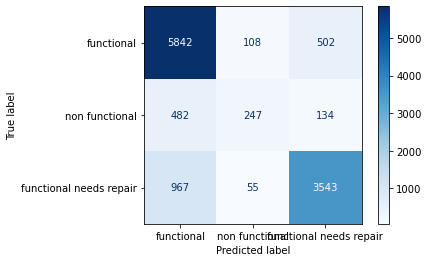

In [482]:
pred = catboost_model.predict(X_test)
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print("Accuracy: {0}".format(accuracy_score(y_test, pred)))
plot_confusion_matrix(catboost_model, X_test, y_test,
                                 display_labels=class_labels,
                                 cmap=plt.cm.Blues)
print(classification_report(y_test,catboost_model.predict(X_test)))

### Create Test Predictions

In [483]:
test_data_cp = test_data.copy(deep=True)

In [484]:
test_data_cp.fillna('unknown', inplace=True)

In [485]:
c = X_train[e].value_counts()
replaced_values = sorted(c.index[c <= 1])
test_data.loc[test_data[e].isin(replaced_values),e] = 'low_freq'

In [486]:
res =  catboost_model.predict(test_data_cp)

In [487]:
res

array([['functional'],
       ['functional'],
       ['functional'],
       ...,
       ['functional'],
       ['functional'],
       ['non functional']], dtype=object)

In [488]:
test_predictions = pd.DataFrame({'status_group' : catboost_model.predict(test_data_cp)[:,0]}, index=test_data_cp.index)

In [489]:
test_predictions.to_csv(r"C:\Users\HP\Desktop\submission_42_8222.csv", index=True, index_label='id')